In [3]:
%matplotlib inline
'''
This script is used for inspecting the anomalies presented in the classification.
'''

'\nThis script is used for inspecting the anomalies presented in the classification.\n'

In [112]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from csv import reader
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from util import plot_confusion_matrix
from collections import Counter

In [7]:
with open('topic.csv', 'r') as f:
    topic_data = list(reader(f))[1:]

    # ground truth labels
    true_labels = [x[0] for x in topic_data]

    # pre-processing raw data
    # merging title and body
    topic_data = [x[2] + ' ' + x[3] for x in topic_data]
    # convert string labels to integer
    le = LabelEncoder()
    y = le.fit_transform(true_labels)
    label_names = le.classes_

    # split training and test data
#     X_train, X_test, y_train, y_test = train_test_split(topic_data, y, test_size=0.2)
#     n_train = len(X_train)

    # create pipeline
    doc_classification = Pipeline(
        [('vect', CountVectorizer(binary=True)),
         ('clf', LogisticRegressionCV())]
    )

    # training the model
    # 3-fold
    y_hat = cross_val_predict(doc_classification, topic_data, y)
    acc = accuracy_score(y, y_hat)

In [55]:
experiment1 = Pipeline(
    [
        ('vect', CountVectorizer(binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

def experiment1_tf_idf(X, y):
    clf = experiment1.fit(X, y)
    y_hat = cross_val_predict(clf, X, y)
    return y_hat

y_hat_1 = experiment1_tf_idf(topic_data, y)
acc_1 = accuracy_score(y, y_hat_1)

In [64]:
expriment2 = Pipeline(
    [
        ('vect', CountVectorizer(binary=False, ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

def experiment2_2_gram(X, y):
    clf = expriment2.fit(X, y)
    y_hat = cross_val_predict(clf, X, y)
    return y_hat

y_hat_2 = experiment2_2_gram(topic_data, y)
acc_2 = accuracy_score(y, y_hat_2)

In [116]:
def experiment(pipeline, X, y, cv=10):
    clf = pipeline.fit(X, y)
    y_hat = cross_val_predict(clf, X, y, cv=cv)
    return y_hat

In [97]:
# remove stop words
experiment3_stop_words = Pipeline(
    [
        ('vect', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

def experiment(pipeline, X, y):
    clf = pipeline.fit(X, y)
    y_hat = cross_val_predict(clf, X, y, cv=10)
    return y_hat
    
y_hat_3 = experiment(experiment3_stop_words, topic_data, y)
acc_3 = accuracy_score(y, y_hat_3)

In [117]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

experiment4_stem = Pipeline(
    [
        ('vect', StemmedCountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

stemmer = SnowballStemmer('english', ignore_stopwords=True)
y_hat_4 = experiment(experiment4_stem, topic_data, y, cv=10)
acc_4 = accuracy_score(y, y_hat_4)

In [ ]:
class LemmatizerCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmatizerCountVectorizer, self).build_analyzer()
        return lambda doc: (lemmatizer.lemmatize(w) for w in analyzer(doc))

experiment5_lemmatizing = Pipeline(
    [
        ('vect', LemmatizerCountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegressionCV())
    ]
)

lemmatizer = WordNetLemmatizer()
y_hat_5 = experiment(experiment5_lemmatizing, topic_data, y)
acc_5 = accuracy_score(y, y_hat_5)

In [115]:
'''
This preprocessor is an
'''
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag


class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transforms input data by using NLTK tokenization, lemmatization, and
    other normalization and filtering techniques.
    """

    def __init__(self, stopwords=None, punct=None, lower=True, strip=True):
        """
        Instantiates the preprocessor, which make load corpora, models, or do
        other time-intenstive NLTK data loading.
        """
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = set(stopwords) if stopwords else set(sw.words('english'))
        self.punct      = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        """
        Fit simply returns self, no other information is needed.
        """
        return self

    def inverse_transform(self, X):
        """
        No inverse transformation
        """
        return X

    def transform(self, X):
        """
        Actually runs the preprocessing on each document.
        """
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation (breaking into sentences), then word/punctuation
        tokenization, and finally part of speech tagging. It uses the part of
        speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        """
        Converts the Penn Treebank tag to a WordNet POS tag, then uses that
        tag to perform much more accurate WordNet lemmatization.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [ ]:
def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

experiment5_pos = Pipeline(
    [
        ('vect', NLTKPreprocessor()),
        ('tfidf', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
        ('clf', LogisticRegressionCV())
    ]
)

y_hat_6 = experiment(experiment5_pos, topic_data, y)
acc_6 = accuracy_score(y, y_hat_6)

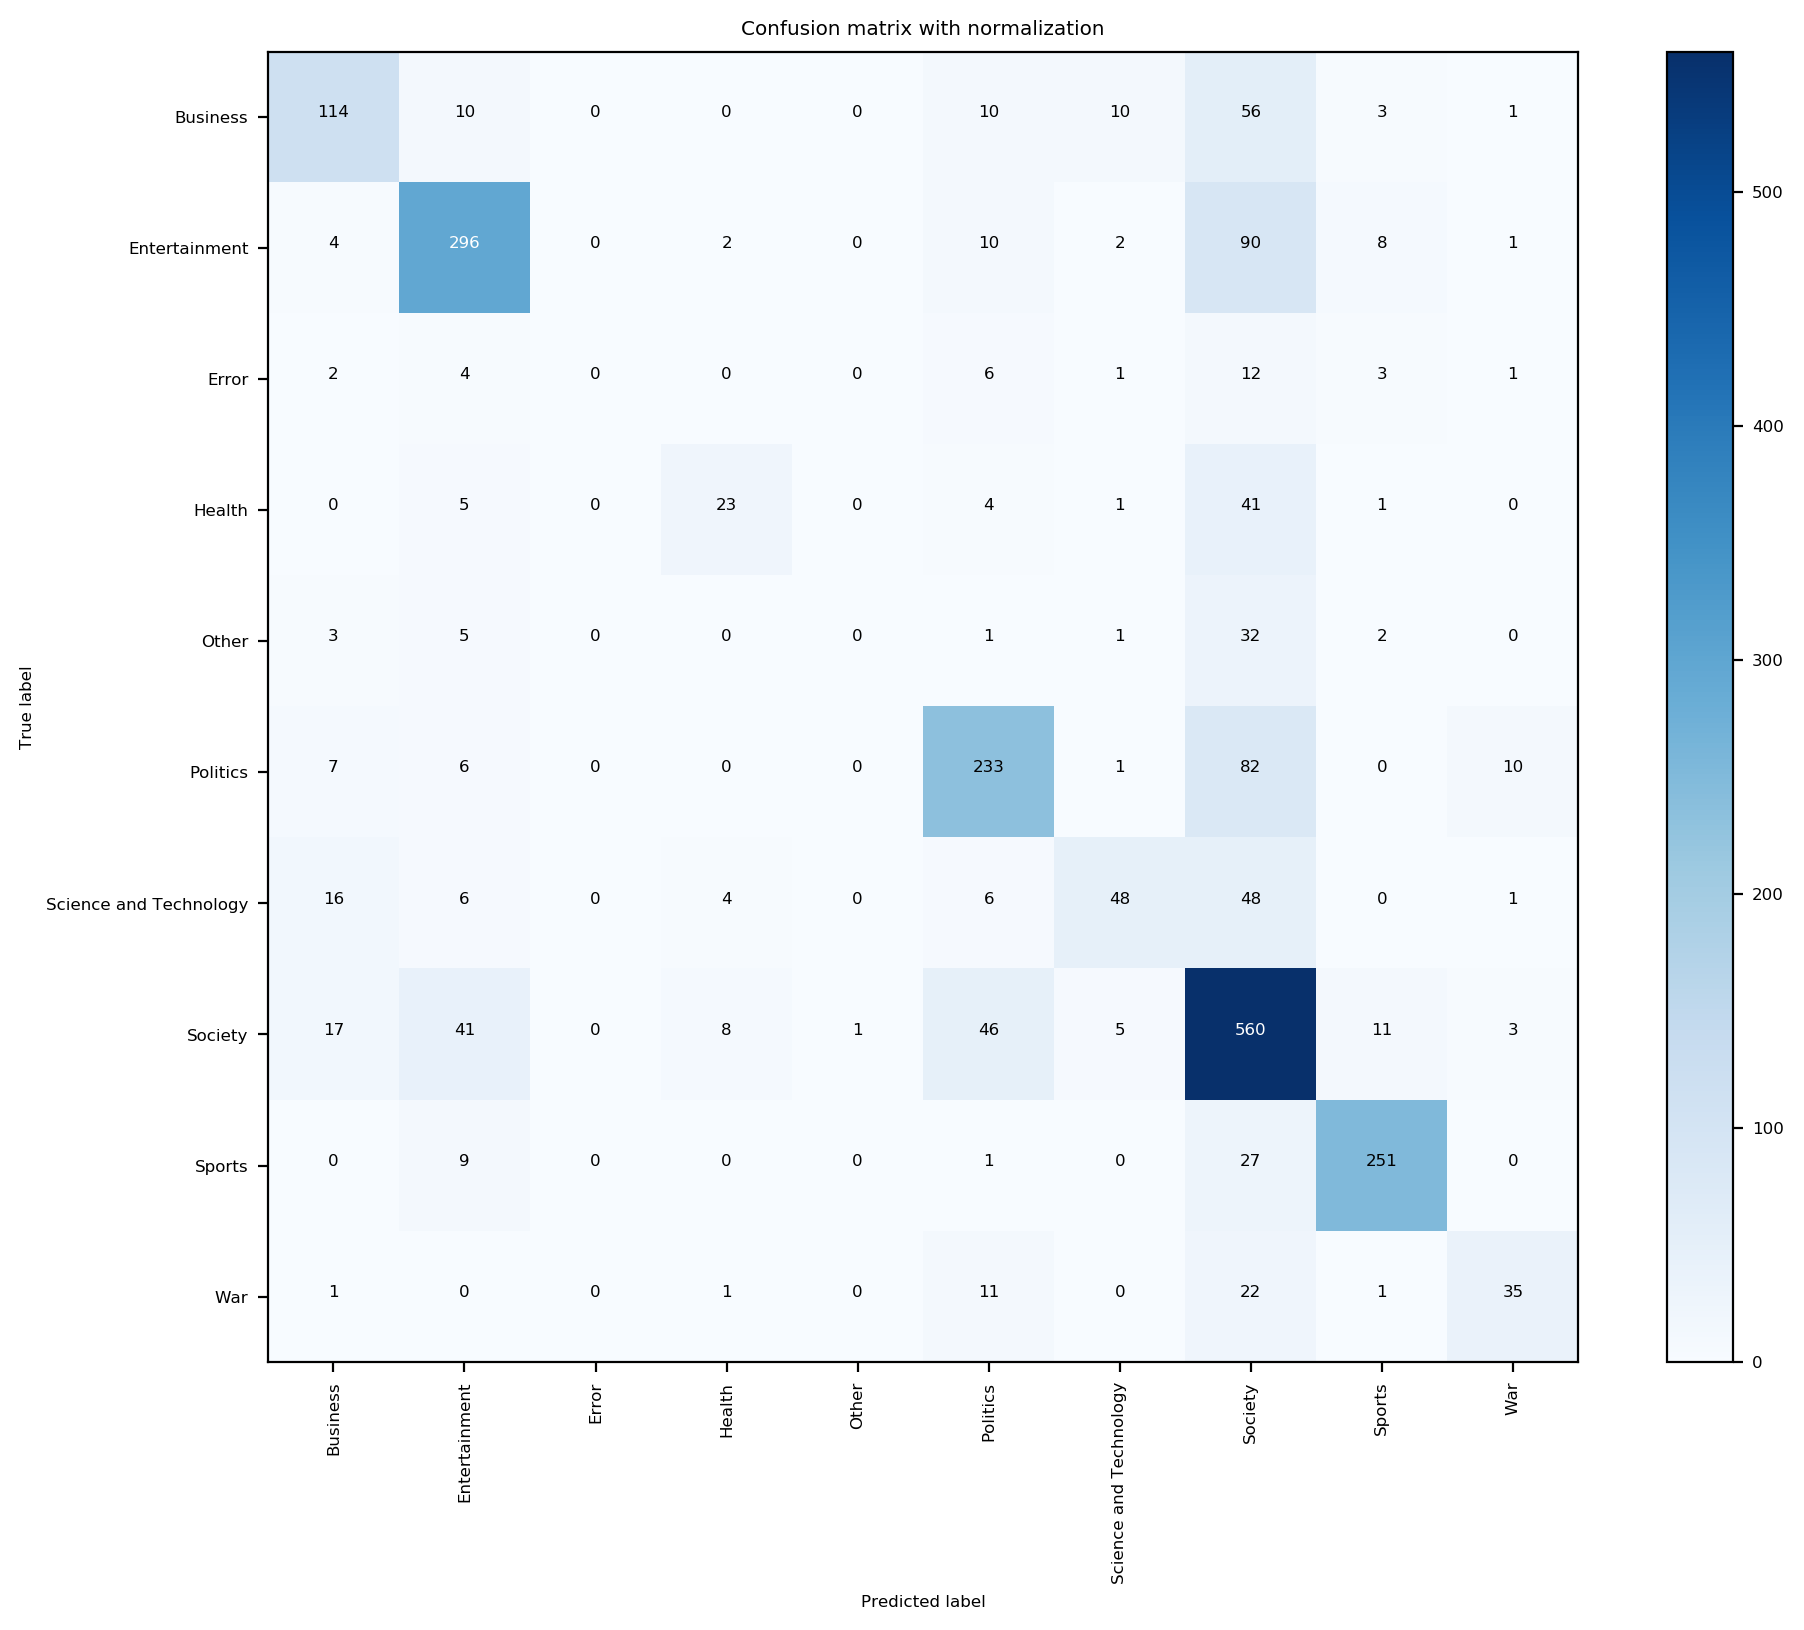

In [121]:
cm = confusion_matrix(y, y_hat_4)
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 8), dpi=200)
plot_confusion_matrix(cm, classes=label_names, normalize=False, title='Confusion matrix with normalization')

In [119]:
misclassified = np.where(y != y_hat_4)
misclassified[0].tolist()

print(acc_4)


0.6830122591943958


In [57]:
def precision(cm, i):
    col = cm[:, i]
    positive = sum(col)
    tp = col[i]
    if positive != 0:
        return tp / positive
    else:
        return float('nan')


def recall(cm , i):
    row = cm[i]
    positive = sum(row)
    tp = row[i]
    if positive != 0:
        return tp / positive
    else:
        return float('nan')

In [95]:
# precision and recall
# labels = label_names.tolist()
# for n in labels:
#     p.append([n, precision(cm, labels.index(n))])
# p = sorted(p, key=lambda x: x[1], reverse=True)

# print('precisions:')
# for i in p:
#     print(i)

r = []
for n in labels:
    r.append([n, recall(cm, labels.index(n))])
r = sorted(r, key=lambda x: x[1], reverse=True)
    
print('recalls:')

for i in r: 
    print(i)

recalls:
['Society', 0.8309248554913294]
['Sports', 0.8125]
['Entertainment', 0.7094430992736077]
['Politics', 0.616519174041298]
['Business', 0.47058823529411764]
['Science and Technology', 0.24806201550387597]
['War', 0.19718309859154928]
['Health', 0.09333333333333334]
['Error', 0.0]
['Other', 0.0]


In [107]:
Counter(true_labels)

Counter({'Business': 204,
         'Entertainment': 413,
         'Error': 29,
         'Health': 75,
         'Other': 44,
         'Politics': 339,
         'Science and Technology': 129,
         'Society': 692,
         'Sports': 288,
         'War': 71})